In [ ]:
!pip install roboflow pycocotools tqdm matplotlib torchvision
!pip install -q segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.4/85.4 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 33.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 35.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.

In [ ]:
!pip install roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="5pEbFhHuFiYqILdQqK0r")
project = rf.workspace("questao2").project("spine_cone-byyoj")
version = project.version(6)
dataset = version.download("coco-segmentation")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to spine_cone-6 in coco-segmentation:: 100%|██████████| 94/94 [00:00<00:00, 5115.87it/s]


In [ ]:
import os
import torch
import torchvision
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.transforms import functional as F
from torchvision.utils import draw_segmentation_masks
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
import json
from pycocotools.coco import COCO
from torchvision import transforms
from sklearn.metrics import f1_score
import torch.nn as nn
import torch.optim as optim
import segmentation_models_pytorch as smp

In [ ]:
# Caminho base do dataset no Google Colab
dataset_path = '/content/spine_cone-6'  # ajuste esse caminho se necessário

# Nomes das subpastas
folders = ['train', 'valid', 'test']

# Extensões válidas para imagens
image_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tif', '.tiff']

# Função para contar imagens
def count_images(folder_path):
    return sum(
        1 for file in os.listdir(folder_path)
        if os.path.splitext(file)[1].lower() in image_extensions
    )

# Contar e exibir o número de imagens em cada pasta
total = 0
for folder in folders:
    path = os.path.join(dataset_path, folder)
    count = count_images(path)
    total += count
    print(f'{folder}: {count} imagens')

print(f'Total: {total} imagens')


train: 69 imagens
valid: 8 imagens
test: 9 imagens
Total: 86 imagens


In [ ]:
class CocoSegmentationDataset(CocoDetection):
    def __init__(self, img_folder, ann_file, transforms=None):
        super().__init__(img_folder, ann_file)
        self._transforms = transforms

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        ann_ids = self.coco.getAnnIds(imgIds=self.ids[idx])
        anns = self.coco.loadAnns(ann_ids)

        mask = np.zeros((img.size[1], img.size[0]), dtype=np.uint8)
        for ann in anns:
            # Verifica se a anotação tem um polígono/RLE válido
            if not ann["segmentation"]:  # Filtra segmentações vazias
                continue

            try:
                cat_id = ann['category_id']
                rle = self.coco.annToMask(ann)  # Gera a máscara binária
                mask[rle > 0] = cat_id  # Atribui o category_id às regiões segmentadas
            except Exception as e:
                print(f"Ignorando anotação inválida (ID {ann['id']}): {e}")
                continue

        mask = Image.fromarray(mask)

        if self._transforms:
            img, mask = self._transforms(img, mask)

        img = transforms.functional.to_tensor(img)
        mask = torch.from_numpy(np.array(mask)).long()

        return img, mask

In [ ]:
class CustomTransform():
    def __call__(self, img, mask):
        img = transforms.functional.resize(img, (640, 640))
        mask = transforms.functional.resize(mask, (640, 640), interpolation=transforms.InterpolationMode.NEAREST)
        return img, mask

def get_loader(folder, batch_size=8):
    img_dir = os.path.join(folder)
    ann_path = os.path.join(folder, "_annotations.coco.json")
    dataset = CocoSegmentationDataset(img_dir, ann_path, transforms=CustomTransform())
    return DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)

# Cria os DataLoaders
train_loader = get_loader(dataset.location + "/train")
val_loader = get_loader(dataset.location + "/valid")
test_loader = get_loader(dataset.location + "/test")

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [ ]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0

    for imgs, masks in tqdm(loader, desc="Treinando"):
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        output = model(imgs)
        loss = criterion(output, masks.long())
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    return total_loss / len(loader)


def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, masks in tqdm(loader):
            imgs, masks = imgs.to(device), masks.to(device)
            outputs = model(imgs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            y_pred.extend(preds.flatten())
            y_true.extend(masks.cpu().numpy().flatten())
    f1 = f1_score(y_true, y_pred, average='macro')
    return f1

In [ ]:
# Configuração do dispositivo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modelo DeepLabV3+ com encoder ResNet-50
model = smp.DeepLabV3Plus(
    encoder_name="resnet50",
    encoder_weights="imagenet",
    in_channels=3,
    classes=2,
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

n_epochs = 50
for epoch in range(n_epochs):
    print(f"\nÉpoca {epoch+1}/{n_epochs}")
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_f1 = evaluate(model, val_loader)
    print(f"Loss de treino: {train_loss:.4f} | F1 Val: {val_f1:.4f}")


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]


Época 1/50


100%|██████████| 1/1 [00:01<00:00,  1.07s/it]


Loss de treino: 0.8033 | F1 Val: 0.4229

Época 2/50


100%|██████████| 1/1 [00:01<00:00,  1.09s/it]


Loss de treino: 0.5882 | F1 Val: 0.2987

Época 3/50


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Loss de treino: 0.4069 | F1 Val: 0.6048

Época 4/50


100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


Loss de treino: 0.2975 | F1 Val: 0.8072

Época 5/50


100%|██████████| 1/1 [00:01<00:00,  1.17s/it]


Loss de treino: 0.2304 | F1 Val: 0.8715

Época 6/50


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Loss de treino: 0.2050 | F1 Val: 0.7606

Época 7/50


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Loss de treino: 0.1779 | F1 Val: 0.8509

Época 8/50


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Loss de treino: 0.1553 | F1 Val: 0.8934

Época 9/50


100%|██████████| 1/1 [00:02<00:00,  2.47s/it]


Loss de treino: 0.1348 | F1 Val: 0.8919

Época 10/50


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Loss de treino: 0.1260 | F1 Val: 0.8893

Época 11/50


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Loss de treino: 0.1191 | F1 Val: 0.9020

Época 12/50


100%|██████████| 1/1 [00:01<00:00,  1.48s/it]


Loss de treino: 0.1115 | F1 Val: 0.8968

Época 13/50


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Loss de treino: 0.1072 | F1 Val: 0.8775

Época 14/50


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Loss de treino: 0.0989 | F1 Val: 0.9064

Época 15/50


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Loss de treino: 0.0905 | F1 Val: 0.9095

Época 16/50


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Loss de treino: 0.0878 | F1 Val: 0.9094

Época 17/50


100%|██████████| 1/1 [00:01<00:00,  1.37s/it]


Loss de treino: 0.0824 | F1 Val: 0.9057

Época 18/50


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Loss de treino: 0.0812 | F1 Val: 0.9066

Época 19/50


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Loss de treino: 0.0801 | F1 Val: 0.9095

Época 20/50


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Loss de treino: 0.0773 | F1 Val: 0.9063

Época 21/50


100%|██████████| 1/1 [00:01<00:00,  1.20s/it]


Loss de treino: 0.0722 | F1 Val: 0.9126

Época 22/50


100%|██████████| 1/1 [00:01<00:00,  1.47s/it]


Loss de treino: 0.0696 | F1 Val: 0.9129

Época 23/50


100%|██████████| 1/1 [00:01<00:00,  1.52s/it]


Loss de treino: 0.0668 | F1 Val: 0.9133

Época 24/50


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Loss de treino: 0.0656 | F1 Val: 0.9142

Época 25/50


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Loss de treino: 0.0642 | F1 Val: 0.9132

Época 26/50


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Loss de treino: 0.0625 | F1 Val: 0.9150

Época 27/50


100%|██████████| 1/1 [00:01<00:00,  1.43s/it]


Loss de treino: 0.0601 | F1 Val: 0.9141

Época 28/50


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Loss de treino: 0.0587 | F1 Val: 0.9111

Época 29/50


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Loss de treino: 0.0571 | F1 Val: 0.9146

Época 30/50


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Loss de treino: 0.0547 | F1 Val: 0.9162

Época 31/50


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Loss de treino: 0.0536 | F1 Val: 0.9046

Época 32/50


100%|██████████| 1/1 [00:01<00:00,  1.18s/it]


Loss de treino: 0.0524 | F1 Val: 0.9083

Época 33/50


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Loss de treino: 0.0515 | F1 Val: 0.8966

Época 34/50


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Loss de treino: 0.0500 | F1 Val: 0.9158

Época 35/50


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Loss de treino: 0.0498 | F1 Val: 0.9155

Época 36/50


100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


Loss de treino: 0.0479 | F1 Val: 0.9179

Época 37/50


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Loss de treino: 0.0468 | F1 Val: 0.9202

Época 38/50


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Loss de treino: 0.0458 | F1 Val: 0.9212

Época 39/50


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Loss de treino: 0.0442 | F1 Val: 0.9187

Época 40/50


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Loss de treino: 0.0436 | F1 Val: 0.9211

Época 41/50


100%|██████████| 1/1 [00:01<00:00,  1.41s/it]


Loss de treino: 0.0433 | F1 Val: 0.9192

Época 42/50


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Loss de treino: 0.0421 | F1 Val: 0.9206

Época 43/50


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Loss de treino: 0.0412 | F1 Val: 0.9226

Época 44/50


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Loss de treino: 0.0405 | F1 Val: 0.9224

Época 45/50


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Loss de treino: 0.0397 | F1 Val: 0.9232

Época 46/50


100%|██████████| 1/1 [00:01<00:00,  1.54s/it]


Loss de treino: 0.0390 | F1 Val: 0.9214

Época 47/50


100%|██████████| 1/1 [00:01<00:00,  1.13s/it]


Loss de treino: 0.0382 | F1 Val: 0.9225

Época 48/50


100%|██████████| 1/1 [00:01<00:00,  1.12s/it]


Loss de treino: 0.0371 | F1 Val: 0.9224

Época 49/50


100%|██████████| 1/1 [00:01<00:00,  1.14s/it]


Loss de treino: 0.0368 | F1 Val: 0.9252

Época 50/50


100%|██████████| 1/1 [00:01<00:00,  1.15s/it]


Loss de treino: 0.0362 | F1 Val: 0.9225



Visualizando previsões...


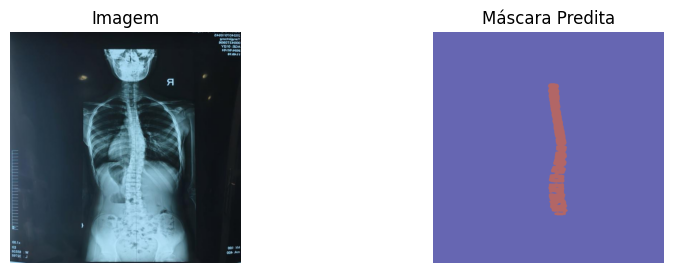

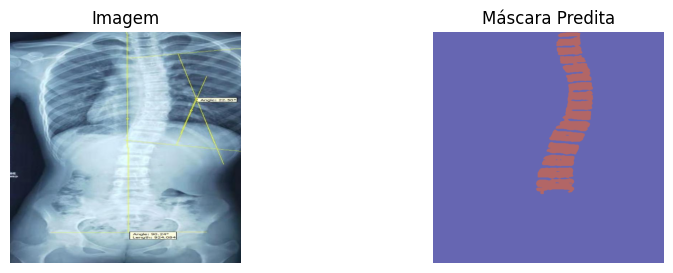

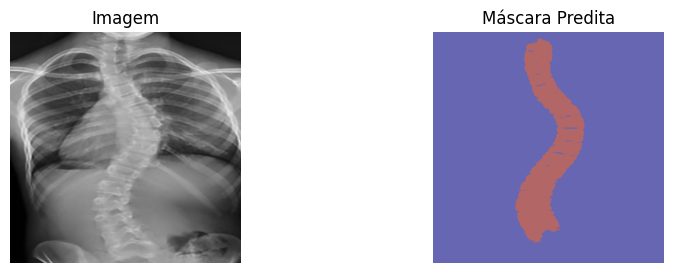

Métricas:
IoU: 0.8603
Dice: 0.9199
Precision: 0.8974
Recall: 0.9455
F1-Score: 0.9199
Pixel Accuracy: 0.9870


In [ ]:
def show_predictions(model, loader, n=3):
    model.eval()
    imgs, masks = next(iter(loader))
    imgs, masks = imgs.to(device), masks.to(device)
    with torch.no_grad():
        outputs = model(imgs)
        preds = torch.argmax(outputs, dim=1)

    for i in range(n):
        img = imgs[i].cpu()
        mask = preds[i].cpu().numpy()

        plt.figure(figsize=(10,3))
        plt.subplot(1,2,1)
        plt.title("Imagem")
        plt.imshow(img.permute(1,2,0))
        plt.axis('off')

        plt.subplot(1,2,2)
        plt.title("Máscara Predita")
        plt.imshow(mask, cmap='jet', alpha=0.6)
        plt.axis('off')
        plt.show()

    metrics = segmentation_metrics(preds, masks)
    print("Métricas:")
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")

print("\nVisualizando previsões...")
show_predictions(model, test_loader)

In [ ]:
import torch
import numpy as np

def segmentation_metrics(preds, targets, num_classes=2):
    preds = preds.cpu().numpy().astype(np.uint8)
    targets = targets.cpu().numpy().astype(np.uint8)

    iou_list = []
    dice_list = []
    precision_list = []
    recall_list = []
    f1_list = []

    for cls in range(num_classes):
        pred_cls = (preds == cls)
        target_cls = (targets == cls)

        intersection = np.logical_and(pred_cls, target_cls).sum()
        union = np.logical_or(pred_cls, target_cls).sum()
        pred_sum = pred_cls.sum()
        target_sum = target_cls.sum()

        precision = intersection / (pred_sum + 1e-6)
        recall = intersection / (target_sum + 1e-6)
        f1 = 2 * precision * recall / (precision + recall + 1e-6)
        dice = (2. * intersection) / (pred_sum + target_sum + 1e-6)
        iou = intersection / (union + 1e-6)

        iou_list.append(iou)
        dice_list.append(dice)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_list.append(f1)

    pixel_acc = (preds == targets).sum() / np.prod(targets.shape)

    return {
        'IoU': np.mean(iou_list),
        'Dice': np.mean(dice_list),
        'Precision': np.mean(precision_list),
        'Recall': np.mean(recall_list),
        'F1-Score': np.mean(f1_list),
        'Pixel Accuracy': pixel_acc
    }

In [ ]:
# Salvar
torch.save(model.state_dict(), "deeplabv3plus_escoliose.pth")

In [ ]:
# Carregar
model = smp.DeepLabV3Plus(
    encoder_name="resnet50",
    encoder_weights=None,  # <- não carrega pesos do ImageNet, pois vai sobrescrever
    in_channels=3,
    classes=2
).to(device)

model.load_state_dict(torch.load("deeplabv3plus_escoliose.pth"))
model.eval()  # Coloca o modelo em modo de avaliação


DeepLabV3Plus(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia